In [1]:
import traceback
import numpy as np
import pandas as pd
import datatable as dt
import gc
import time
import os
import xgboost as xgb
import talib as ta
from script.crypto_API import *

In [2]:
ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

In [3]:
############################################# features: faster for submission
def log_return(series, periods=5):
    #ta.LN(series).diff(periods=periods)
    return np.log(series).diff(periods=periods)

def upper_shadow(df):
    return ta.SUB(df['High'], np.maximum(df['Close'], df['Open']))

def lower_shadow(df):   
    return ta.SUB(np.minimum(df['Close'], df['Open']), df['Low'] )


def lag_features(df):
    #Close-log-return
    df['lrtn_close_5'] = log_return(df['Close'],periods=5)
    df['lrtn_close_15'] = log_return(df['Close'],periods=15)
    df['lrtn_index_5'] = log_return(df['Crypto_Index'],periods=5)
    df['lrtn_index_15'] = log_return(df['Crypto_Index'],periods=15)
    #15minutes-volume-sum/delta, on-balance-volume
    df['vol_sum_15'] = ta.SMA(df['Volume'],15)*15
    df['vol_delta_15'] = df['vol_sum_15'].diff()
    df['vol_pressure_1']=np.sign(df['Close'].diff(1)) * df['Volume']
    df['vol_pressure_15']=ta.MULT(np.sign(df['Close'].diff(15)), df['vol_sum_15'])
    
    #tech analysis indicators
    df['rsi_15'] = ta.RSI(df['Close'], timeperiod=15)
    df['macd_15_30'],macdsignal, MACD_HIST = ta.MACD(df['Close'], fastperiod=15, slowperiod=30, signalperiod=5)
    #band_up,band_down=get_bollinger_bands(prices=df['Close'],sma=close_sma_15,window=15)
    band_up, mid_band, band_down = ta.BBANDS(df['Close'], timeperiod=15, nbdevup=2, nbdevdn=2, matype=0)
    df['close_bollinger_up_15'] = ta.SUB(band_up, df['Close'])
    df['close_bollinger_down_15'] = ta.SUB(df['Close'], band_down)

def get_features(df_feat, lagfeatures=False):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    if lagfeatures:
        lag_features(df_feat)
    return df_feat

In [4]:
from os.path import exists
def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

models=model_reload_train(param_version=20)
models[0].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'VWAP',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'Upper_Shadow',
 'Lower_Shadow',
 'lrtn_close_5',
 'lrtn_index_5',
 'lrtn_index_15',
 'vol_sum_15',
 'vol_delta_15',
 'vol_pressure_15',
 'rsi_15',
 'macd_15_30',
 'close_bollinger_up_15',
 'close_bollinger_down_15']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

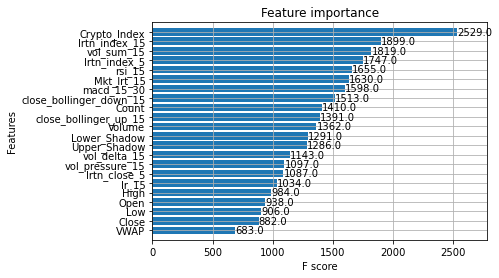

In [5]:
xgb.plot_importance(models[13],height=0.8)

In [6]:
pre_minute=40
add_weight_map = dict(zip(df_asset_details.Asset_ID,df_asset_details.Weight/df_asset_details.Weight.sum()))

###load sup_train
sup_train = pd.read_csv('./data/supplemental_train.csv')
sup_train = sup_train.sort_values('timestamp').set_index("timestamp")
sup_train = sup_train.sort_index()
ind = sup_train.index.unique()
###consistent timestamp for all 14 assets
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
sup_train = sup_train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
sup_train = sup_train.iloc[(-14*pre_minute):,:]
#clean VWAP
sup_train.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
sup_train['VWAP']=sup_train['VWAP'].fillna((sup_train['High']+sup_train['Low'])/2)
#add weight
sup_train['Weight'] = sup_train['Asset_ID'].map(add_weight_map)
sup_train.drop('Target',axis=1, inplace=True)
sup_train.set_index('Asset_ID',append=True, inplace=True)
#sup_train

In [7]:
from sys import stdout
start = datestring_to_timestamp('2021-06-13-00-00')
end = datestring_to_timestamp('2021-09-22-01-00')
train_df = read_csv_slice(file_path='./data/train.csv',use_window=[start, end])

print('Start submission API')
myapi = API(train_df)
from datetime import datetime 
start_time = datetime.now()

for (df_test, df_pred) in myapi:
    test_timestamp = df_test.timestamp.values[0]
    stdout.write(f"\r{test_timestamp}_{pd.to_datetime(test_timestamp, unit='s',infer_datetime_format=True)}")
    stdout.flush()
    
    num_asset_test = df_test.shape[0]
    row_asset_id_map = dict(zip(df_test.row_id, df_test.Asset_ID))
    #######################################clean VWAP
    df_test.replace(to_replace=[np.inf, -np.inf],value= np.nan, inplace=True)
    df_test['VWAP']=df_test['VWAP'].fillna((df_test['High']+df_test['Low'])/2)
    #######################################add weight and index
    df_test['Weight'] = df_test['Asset_ID'].map(add_weight_map)
    ########################################fill in missing assets, added to sup_train
    df_test.set_index(['timestamp','Asset_ID'],inplace=True)
    df_test = df_test.reindex(list(zip([test_timestamp]*14,range(14))))
    
    sup_train = pd.concat([sup_train,df_test[sup_train.columns]])
    sup_train=sup_train.reset_index('Asset_ID').groupby('Asset_ID').apply(lambda x: x.fillna(method="ffill"))
    sup_train = sup_train.set_index('Asset_ID', append=True).iloc[(-14*pre_minute):,:]
    sup_train2 = sup_train.copy()
    #######################################add lr_15,mkt_lr_15,crypto_index
    lr_15 = sup_train2.groupby('Asset_ID').apply( 
            lambda x: log_return(x[['Close']],15)
            )
    sup_train2['lr_15'] = lr_15['Close']
    mkt_lr_15 = sup_train2.groupby('timestamp').apply( 
        lambda x: x[["lr_15", "VWAP"]].multiply(x["Weight"], axis="index").sum()
        )
    mkt_lr_15.columns = ['Mkt_lrt_15','Crypto_Index']
    firsts = sup_train2.index.get_level_values('timestamp')
    sup_train2[['Mkt_lrt_15','Crypto_Index']] = mkt_lr_15.loc[firsts].values
    #######################################add features to test timestamp
    xx_test=sup_train2.groupby('Asset_ID').apply(
        lambda x: get_features(x, lagfeatures=True)
    ).loc[df_test.index.get_level_values('timestamp')[0]]
    
    #rdy for prediction
    y_pred=df_test.apply(lambda row: models[row.name[1]].predict(
                            xgb.DMatrix(pd.DataFrame([xx_test.loc[row.name[1],models[row.name[1]].feature_names]]))
                                                                )[-1]
                         ,axis =1)
    #match with row_id
    y_pred.reset_index('timestamp',drop=True,inplace=True)
    df_pred['Target']= y_pred.loc[df_pred['row_id'].map(row_asset_id_map)].values
    myapi.predict(df_pred)
    #break

time_elapsed = datetime.now() - start_time
print('Time elapsed total (hh:mm:ss.ms) {}'.format(time_elapsed))
print(f'time elapsed per iteration {time_elapsed/4}')
print(f'Submission time estimate {129600*time_elapsed/4}')

Start submission API
This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set. ;)
1624479720_2021-06-23 20:22:00

KeyboardInterrupt: 

In [10]:
##scoring
id_2_weight = dict(zip(df_asset_details.Asset_ID, df_asset_details.Weight))
df, score = myapi.score(id_2_weight)
print(f"Your LB score is {round(score, 4)}")

Your LB score is nan
